In [ ]:

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from __future__ import print_function, division

In [ ]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar xfz aclImdb_v1.tar.gz

--2022-12-03 18:31:35--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  14.3MB/s    in 9.1s    

2022-12-03 18:31:44 (8.85 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
# Imports libraries and packages and saves all unique stop words

import re #import regular expression
from nltk.corpus import stopwords # import stop words list
import nltk # import Natural language toolkit
from nltk.stem import WordNetLemmatizer #Lemmetization

from nltk.tokenize import word_tokenize # word_tokenize is a function that splits a given sentence into words using the NLTK library.
nltk.download('stopwords') #  Download stopwords from NLTK library
nltk.download('punkt') # punkt is the required package for tokenization
stopWords=set(stopwords.words('english')) # stores all unique english stop words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# The input text is converted to tokens. The tokens are then Lemmatized. 

def text_tokens(text):
    #Lower
    text = text.lower()

    #replace tabs space with normal space
    text = re.sub("\\s", " ", text) 

    # remove special characters  
    pattern = r'[^A-Za-z]+'
    text = re.sub(pattern, ' ', text)

    #Remove stop words from the text
    word_tokens = word_tokenize(text)
    tokens = []
    for word in word_tokens:
        if word not in stopWords:
            tokens.append(word)

    # Lemmatization 
    lemma_tokens=[]
    lemmatizer = WordNetLemmatizer()
    for word in tokens:
      lemma_tokens.append(lemmatizer.lemmatize(word))

 #   print("Lemma text: ",lemma_tokens)

    return lemma_tokens

In [ ]:

import os
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

def load_dataset(dirname):
    X, y = [], []
    
    for y_val, y_label in enumerate(['neg', 'pos']):
        y_dir = os.path.join(dirname, y_label)
        for fname in os.listdir(y_dir):
            fpath = os.path.join(y_dir, fname)
            # print('\r' + fpath + '   ', end='')
            with open(fpath) as f:
                tokens = text_tokens(f.read())
            X.append(tokens)
            y.append(y_val)  # 0 for 'neg', 1 for 'pos'
    print()
    return X, y

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# train dataset
X_train, y_train = load_dataset('aclImdb/train/')
# validation dataset
X_val, y_val = load_dataset('aclImdb/test/')

In [ ]:
len(X_train), len(X_val)

(25000, 25000)

In [ ]:
# Vocabulary: All words used, starting by the most frequent
with open('aclImdb/imdb.vocab') as f:
    vocab = [word.rstrip() for word in f]
    # Keep only most frequent 5000 words
    vocab = vocab[:5000]
    print('%d words in vocabulary' % (len(vocab),))

5000 words in vocabulary


Bag of words : Linear Model

In [ ]:
import pandas as pd
column_names = ["Model", "Train_Accuracy","Test_Accuracy"]
Accuracy_Table = pd.DataFrame(columns = column_names)

In [ ]:
def onehot_vector(tokens):
    vector_tokens = [0] * len(vocab)
    for t in tokens:
        try:
            # mark the value as 1 in vector_tokens for the word in vocab
            vector_tokens[vocab.index(t)] = 1
        except:
            pass 
    return vector_tokens

In [ ]:
from tqdm import tqdm

# convert the x_train and x_val dataset into one-hot (numerical value)
X_train_bow = [onehot_vector(x) for x in tqdm(X_train)] 
X_val_bow = [onehot_vector(x) for x in tqdm(X_val)]

100%|██████████| 25000/25000 [01:13<00:00, 339.40it/s]


In [ ]:
def train_history(history):
    best_epoch = np.argmax(history.history['val_accuracy'])
    print('Accuracy (epoch %d): %.4f train, %.4f val' % 
          (best_epoch + 1, history.history['accuracy'][best_epoch], history.history['val_accuracy'][best_epoch]))

In [ ]:
from tensorflow import keras 
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.models import Model
import numpy as np


class BOWSentimentModel(object):
    #initialize the model with the input and output for the dense layer
    def __init__(self):
        input_bow = Input(shape=(len(vocab),), name='input_bow')
        # 1 output from the model
        net_sentiment = Dense(1)(input_bow)
        net_sentiment = Activation('sigmoid')(net_sentiment)

        self.model = Model(inputs=[input_bow], outputs=[net_sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Applying model fitting: ')
        return self.model.fit(X, y, validation_data=(X_val, y_val), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment_model = BOWSentimentModel()
history = sentiment_model.train(X_train_bow, y_train, X_val_bow, y_val)
train_history(history)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_bow (InputLayer)      [(None, 5000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 5001      
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________
Applying model fitting: 
Epoch 1/10
782/782 [==============================] - 404s 515ms/step - loss: 0.4612 - accuracy: 0.8362 - val_loss: 0.3699 - val_accuracy: 0.8706
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3216 - accuracy: 0.8868 - val_loss: 0.3223 - val_accuracy: 0.8796
Epoch 3/10

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Bag of Words Linear Model",90.54,88.12]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12


In [ ]:
text = 'Great movie,great cast,great music,this is one of those movies that is so good that when it is over you wish it would go on for another 90 minutes,I will w3atch this one many times.'
test_tokens = text_tokens(text)
print(text)
print(sentiment_model.predict([onehot_vector(test_tokens)])[0])

text = 'I found the acting to be pretty good considering the genre of movie and its obvious low budget. I dont know what was going on with the cinematography but it looked ghastly. Way too over-saturated. Maybe this is a bad transfer to DVD or maybe it always looked like that, I dont know. There really are no redeeming qualities to speak of. There are a few deaths but not really gory.'
test_tokens = text_tokens(text)
print(text)
print(sentiment_model.predict([onehot_vector(test_tokens)])[0])

Great movie,great cast,great music,this is one of those movies that is so good that when it is over you wish it would go on for another 90 minutes,I will w3atch this one many times.
1/1 [==============================] - 0s 58ms/step
[0.5657544]
I found the acting to be pretty good considering the genre of movie and its obvious low budget. I dont know what was going on with the cinematography but it looked ghastly. Way too over-saturated. Maybe this is a bad transfer to DVD or maybe it always looked like that, I dont know. There really are no redeeming qualities to speak of. There are a few deaths but not really gory.
1/1 [==============================] - 0s 17ms/step
[0.09723669]


In [ ]:
import matplotlib.pyplot as plt
# plot the results
def plot_train_history(history):
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['acc', 'val_acc'])
    plt.show()

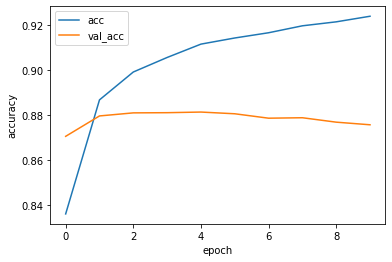

In [ ]:
plot_train_history(history)

Bag of Words with Hidden Layers

In [ ]:
from keras.layers import Activation, Dense, Input
from keras.models import Model
import numpy as np

class BOWHiddenSentimentModel(object):
    def __init__(self, N=64):
        input_bow = Input(shape=(len(vocab),), name='input_bow')
        # 64 nodes in the first layer
        hidden = Dense(N, activation='tanh')(input_bow)
        # 1 output node in the last layer
        net_sentiment = Dense(1, activation='sigmoid')(hidden)

        self.model = Model(inputs=[input_bow], outputs=[net_sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Applying Model Fitting: ')
        return self.model.fit(np.array(X), np.array(y), validation_data=(np.array(X_val), np.array(y_val)), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment_model = BOWHiddenSentimentModel()
history = sentiment_model.train(X_train_bow, y_train, X_val_bow, y_val)
train_history(history)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_bow (InputLayer)      [(None, 5000)]            0         
                                                                 
 dense_1 (Dense)             (None, 64)                320064    
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 320,129
Trainable params: 320,129
Non-trainable params: 0
_________________________________________________________________
Applying Model Fitting: 
Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3303 - accuracy: 0.8612 - val_loss: 0.3031 - val_accuracy: 0.8722
Epoch 2/10
782/782 [==============================] - 5s 7ms/step - loss: 0.2434 - accuracy: 0.9017 - val_loss: 0.3072 - val_accuracy: 0.8700
Epoch 3/

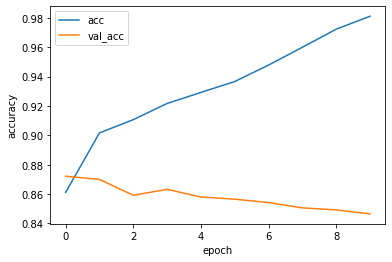

In [ ]:
plot_train_history(history)

In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Bag of Words with Hidden Layers | 64 Nodes",86.23,87.20]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20


Bag of words with 128 nodes

In [ ]:
from keras.layers import Activation, Dense, Dropout, Input
from keras.models import Model
from keras import regularizers
import numpy as np

class BOWHiddenRegularizedSentimentModel(object):
    def __init__(self, N=128):
        input_bow = Input(shape=(len(vocab),), name='input_bow')
        # uses 128 nodes in the first dense layer
        # dropout randomly sets input node to 0 to avoid overfitting during training [rate = 1/1-r]
        hidden = Dropout(0.5)(Dense(N, kernel_regularizer=regularizers.l2(1e-3))(input_bow))
        # out of hidden layer is fed as input to the dense layer
        net_sentiment = Dense(1, activation='sigmoid')(hidden)

        self.model = Model(inputs=[input_bow], outputs=[net_sentiment])
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train(self, X, y, X_val, y_val):
        print('Applying Model Fitting: ')
        return self.model.fit(np.array(X), np.array(y), validation_data=(np.array(X_val), np.array(y_val)), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment_model = BOWHiddenRegularizedSentimentModel()
history = sentiment_model.train(X_train_bow, y_train, X_val_bow, y_val)
train_history(history)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_bow (InputLayer)      [(None, 5000)]            0         
                                                                 
 dense_3 (Dense)             (None, 128)               640128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 640,257
Trainable params: 640,257
Non-trainable params: 0
_________________________________________________________________
Applying Model Fitting: 
Epoch 1/10
782/782 [==============================] - 7s 8ms/step - loss: 0.4786 - accuracy: 0.8552 - val_loss: 0.4589 - val_accuracy: 0.8644
Epoch 2/10
782/782

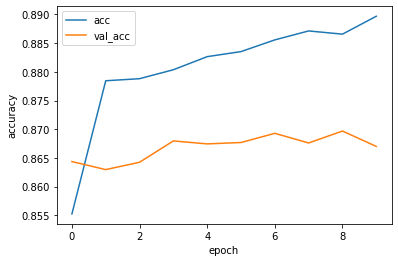

In [ ]:
plot_train_history(history)

In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Bag of Words with Hidden Layers | 128 Nodes",88.30,87.06]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06


Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB  # The Multinomial Naïve Bayes classifier is used when the data is multinomial distributed. 

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train_bow, y_train)   # Fit MNB classifier according to the training dataset.

MultinomialNB()

In [ ]:
from sklearn import metrics
predict_train_data = MNB.predict(X_train_bow) # Predicts training set result
accuracy_score1=metrics.accuracy_score(y_train, predict_train_data) #the set of labels predicted must exactly match the corresponding set of labels in y_train. 
predict_test_data = MNB.predict(X_val_bow) # Predicts test set result
accuracy_score2 = metrics.accuracy_score(y_val, predict_test_data)  # the set of labels predicted must exactly match the corresponding set of labels in y_val. 

In [ ]:
print(str('{:04.2f}'.format(accuracy_score1*100))+'%')
print(str('{:04.2f}'.format(accuracy_score2*100))+'%')

86.27%
84.64%


In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Naive Bayes",86.27,84.64]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
LR=LogisticRegression()
LR.fit(X_train_bow, y_train) # 	Fit the model according to the training data

LogisticRegression()

In [ ]:
predict_train_data=LR.predict(X_train_bow) # Predicts training labels for samples in X.
accuracy_score1 = metrics.accuracy_score(y_train, predict_train_data) # the set of labels predicted must exactly match the corresponding set of labels in y_true. 
predict_test_data = LR.predict(X_val_bow) # Predicts testing labels for samples in X.
accuracy_score2 = metrics.accuracy_score(y_val, predict_test_data) # the set of labels predicted must exactly match the corresponding set of labels in y_true.

In [ ]:
print(str('{:04.2f}'.format(accuracy_score1*100))+'%')
print(str('{:04.2f}'.format(accuracy_score2*100))+'%')

94.35%
85.20%


In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Logistic Regression",94.35,85.20]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64
4,Logistic Regression,94.35,85.20


SVM

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
SM=LinearSVC()
SM.fit(X_train_bow, y_train) # Fit the SVM model according to the given training data.

LinearSVC()

In [ ]:
predict_train_data=SM.predict(X_train_bow) # Perform classification on samples in X train.
accuracy_score1 = metrics.accuracy_score(y_train, predict_train_data) # the set of labels predicted must exactly match the corresponding set of labels in y_true.
predict_test_data = SM.predict(X_val_bow) # Perform classification on samples in X test.
accuracy_score2 = metrics.accuracy_score(y_val, predict_test_data) # the set of labels predicted must exactly match the corresponding set of labels in y_true.

In [ ]:
print(str('{:04.2f}'.format(accuracy_score1*100))+'%')
print(str('{:04.2f}'.format(accuracy_score2*100))+'%')

94.74%
83.07%


In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Support Vector Machine",94.75,83.08]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64
4,Logistic Regression,94.35,85.20
5,Support Vector Machine,94.75,83.08


## GloVe-based Model (let's start with averaging)

Download and extract the official pre-trained GloVe matrix:

In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

--2022-12-03 18:55:03--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-03 18:55:04--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.99MB/s    in 2m 42s  

2022-12-03 18:57:46 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

### Loading GloVe vocabulary

You may need to restart your kernel here if you don't have a lot of free memory, to get rid of the bag-of-words vectors from before.

In [ ]:
EMBEDDING_DIM = 50

In [ ]:
# let's create a dictionary of each word in the pre-trained GloVe embeddings, saving its location indexes 
import os
from tqdm import tqdm
import numpy as np

GLOVE_DIR = "."
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%dd.txt' % EMBEDDING_DIM))
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:04, 97531.21it/s]

Found 400000 word vectors.


In [ ]:
# a matrix that is indexed by our vocabulary, containing
# GloVe embedding for each vocabulary element
embedding_matrix = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
for i, word in enumerate(vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        # also, [0] is reserved for padding
        embedding_matrix[i + 1] = embedding_vector

Checking how many words have no pre-trained GloVe word embeddings:

In [ ]:
1. * np.count_nonzero(np.all(embedding_matrix == 0, axis=1)) / len(vocab)  # OOV portion

0.0076

We are representing reviews as sequences now.  However, each sequence must have the same length on the input in Keras.  We will pad shorter sequences by zeroes from right, but what should be the maximum sequence length?  Let's find a compromise.

In [ ]:
lengths = sorted([len(X) for X in X_train])
percentile = 0.90
seq_cutoff = lengths[int(len(lengths)*percentile)]
print('Longest: %d, Average: %f, Median: %d, %d%% percentile: %d tokens' % (lengths[-1], np.mean(lengths), lengths[int(len(lengths)*0.5)], percentile*100, seq_cutoff))

Longest: 1442, Average: 123.587600, Median: 91, 90% percentile: 246 tokens


In [ ]:
def vocab_indices_vector(tokens):
    vector = [0] * seq_cutoff
    if len(tokens) > seq_cutoff:
        # Remove the middle
        tokens = tokens[: seq_cutoff // 2] + ['SINGLE_PADDING_IN_THE_MIDDLE'] + tokens[-seq_cutoff // 2 :]
    for i, t in enumerate(tokens):
        try:
            vector[i] = vocab.index(t) + 1  # reserving 0 for padding
        except:
            pass  # ignore missing words
    return vector

In [ ]:
X_indices_train = [vocab_indices_vector(x) for x in tqdm(X_train)]
X_indices_val = [vocab_indices_vector(x) for x in tqdm(X_val)]

100%|██████████| 25000/25000 [01:19<00:00, 313.49it/s]


### GloVe averaging model

In [ ]:
from keras.layers import Activation, GlobalAveragePooling1D, Dense, Embedding, Input
from keras.models import Model
import numpy as np

class GloveAvgSentimentModel(object):
    def __init__(self):
        self.model = self.create()
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input')                    
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        avg_embedded = GlobalAveragePooling1D()(seq_embedded) # this is the reason it's called avg
        sentiment = Dense(1, activation='sigmoid')(avg_embedded)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X), np.array(y), validation_data=(np.array(X_val), np.array(y_val)), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveAvgSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
train_history(history)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 246)]             0         
                                                                 
 embedding (Embedding)       (None, 246, 50)           250050    
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 250,101
Trainable params: 51
Non-trainable params: 250,050
_________________________________________________________________
Fitting...
Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6791 - accuracy: 0.6155 - val_l

In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["Glove Averaging Model",72.69,72.02]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64
4,Logistic Regression,94.35,85.20
5,Support Vector Machine,94.75,83.08
6,Glove Averaging Model,72.69,72.02


### Maximum in a "sentiment predictive" space

In [ ]:
from keras.layers import Activation, GlobalMaxPooling1D, Dense, Embedding, Input
from keras.models import Model
import numpy as np

class GloveHiddenMaxSentimentModel(object):
    def __init__(self, N=64):
        self.model = self.create(N)
        self.model.summary()
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def create(self, N):
        seq_indices = Input(shape=(seq_cutoff,), name='seq_input')                    
        seq_embedded = Embedding(input_dim=len(vocab) + 1, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],
                                 input_length=seq_cutoff, trainable=False)(seq_indices)
        seq_hidden = Dense(N, activation='tanh')(seq_embedded)
        max_hidden = GlobalMaxPooling1D()(seq_hidden)# this is the reason it's called max
        sentiment = Dense(1, activation='sigmoid')(max_hidden)

        return Model(inputs=[seq_indices], outputs=[sentiment])

    def train(self, X, y, X_val, y_val):
        print('Fitting...')
        return self.model.fit(np.array(X, dtype='int32'), np.array(y),validation_data=(np.array(X_val, dtype='int32'), np.array(y_val)), epochs=10, verbose=1)

    def predict(self, X):
        return self.model.predict(np.array(X))
    
sentiment = GloveHiddenMaxSentimentModel()
history = sentiment.train(X_indices_train, y_train, X_indices_val, y_val)
train_history(history)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 246)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 246, 50)           250050    
                                                                 
 dense_6 (Dense)             (None, 246, 64)           3264      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 253,379
Trainable params: 3,329
Non-trainable params: 250,050
_________________________________________________

In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["GloveHiddenMaxSentimentModel",86.47,84.06]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64
4,Logistic Regression,94.35,85.20
5,Support Vector Machine,94.75,83.08
6,Glove Averaging Model,72.69,72.02
7,GloveHiddenMaxSentimentModel,86.47,84.06


LSTM

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras import preprocessing
from keras.preprocessing import sequence
from keras.utils import pad_sequences

Fixing random seed for reproductibility

In [ ]:
numpy.random.seed(7)

Load dataset but keep only top 5000 words, others will be zero

In [ ]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

17464789/17464789 [==============================] - 2s 0us/step


truncating and padding input sequences

In [ ]:
max_review_length = 500
X_train = pad_sequences(X_train, maxlen=max_review_length)
X_test = pad_sequences(X_test, maxlen=max_review_length)

creating the model

In [ ]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=5, batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
391/391 [==============================] - 15s 27ms/step - loss: 0.4958 - accuracy: 0.7551
Epoch 2/5
391/391 [==============================] - 11s 27ms/step - loss: 0.3290 - accuracy: 0.8649
Epoch 3/5
391/391 [==============================] - 11s 27ms/step - loss: 0.2581 - accuracy: 0.8998
Epoch 

Predicting on test data

In [ ]:
pred = model.predict(X_test)
print(pred)

782/782 [==============================] - 6s 8ms/step
[[0.10415655]
 [0.9724405 ]
 [0.24404262]
 ...
 [0.09324919]
 [0.03758823]
 [0.53420395]]


Final evaluation of the model

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.40%


In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["LSTM",92.27,86.28]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64
4,Logistic Regression,94.35,85.20
5,Support Vector Machine,94.75,83.08
6,Glove Averaging Model,72.69,72.02
7,GloveHiddenMaxSentimentModel,86.47,84.06
8,LSTM,92.27,86.28


## BERT

In [ ]:
# Installing Transformers

! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.4 MB/s 
     |████████████████████████████████| 451 kB 66.8 MB/s 
     |████████████████████████████████| 7.6 MB 59.7 MB/s 
     |████████████████████████████████| 182 kB 70.0 MB/s 
     |████████████████████████████████| 212 kB 66.2 MB/s 
     |████████████████████████████████| 132 kB 77.2 MB/s 
     |████████████████████████████████| 127 kB 63.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
#  Build model with the Sequence Classifier and tokenizer with BERT’s Tokenizer.

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
#from transformers import DistilBertTokenizerFast
#from transformers import TFDistilBertForSequenceClassification

#model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
#tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") 


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
import tensorflow as tf
import pandas as pd 

In [ ]:
#Download the dataset

URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')  

In [ ]:
#Remove Unlabeled Reviews since this is a supervised learning task

# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))  

['labeledBow.feat', 'pos', 'unsupBow.feat', 'urls_neg.txt', 'urls_unsup.txt', 'neg', 'urls_pos.txt']


In [ ]:
# Train and Test Split of Train dataset

# We create a training dataset and a validation 
# dataset from our "aclImdb/train" directory with a 80/20 split.
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# converts our train Dataset object to train pandas dataframe

for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()


,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [ ]:
# converts our test Dataset object to train pandas dataframe

for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [ ]:
# Creating Input Sequences from dataset

InputExample(guid=None,
             text_a = "Hello, world",
             text_b = None,
             label = 1)


InputExample(guid=None, text_a='Hello, world', text_b=None, label=1)



Now we will create two main functions:

1 — convert_data_to_examples: This will accept our train and test datasets and convert each row into an InputExample object.

2 — convert_examples_to_tf_dataset: This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.


In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                           test, 
                                                                           'DATA_COLUMN', 
                                                                           'LABEL_COLUMN')
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
# call the functions we created above

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)


Our dataset containing processed input sequences are ready to be fed to the model.


Adam as our optimizer, CategoricalCrossentropy as our loss function, and SparseCategoricalAccuracy as our accuracy metric. Fine-tuning the model for 2 epochs will give us around 97% accuracy,


In [ ]:
# Configuring the BERT model and Fine-tuning

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
1250/1250 [==============================] - 1171s 917ms/step - loss: 0.2659 - accuracy: 0.8869 - val_loss: 0.3431 - val_accuracy: 0.8796
Epoch 2/2
1250/1250 [==============================] - 1141s 913ms/step - loss: 0.0760 - accuracy: 0.9738 - val_loss: 0.4510 - val_accuracy: 0.8844


In [ ]:
Accuracy_Table.loc[len(Accuracy_Table)]=["TFBertForSequenceClassification",97.32,87.70]
Accuracy_Table

,Model,Train_Accuracy,Test_Accuracy
0,Bag of Words Linear Model,90.54,88.12
1,Bag of Words with Hidden Layers | 64 Nodes,86.23,87.20
2,Bag of Words with Hidden Layers | 128 Nodes,88.30,87.06
3,Naive Bayes,86.27,84.64
4,Logistic Regression,94.35,85.20
5,Support Vector Machine,94.75,83.08
6,Glove Averaging Model,72.69,72.02
7,GloveHiddenMaxSentimentModel,86.47,84.06
8,LSTM,92.27,86.28
9,TFBertForSequenceClassification,97.32,87.70


Making Predictions


In [ ]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']


We need to tokenize our reviews with our pre-trained BERT tokenizer. We will then feed these tokenized sequences to our model and run a final softmax layer to get the predictions. We can then use the argmax function to determine whether our sentiment prediction for the review is positive or negative.

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
  print(pred_sentences[i], ": \n", labels[label[i]])

This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good : 
 Positive
One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie : 
 Negative


## Conclusion

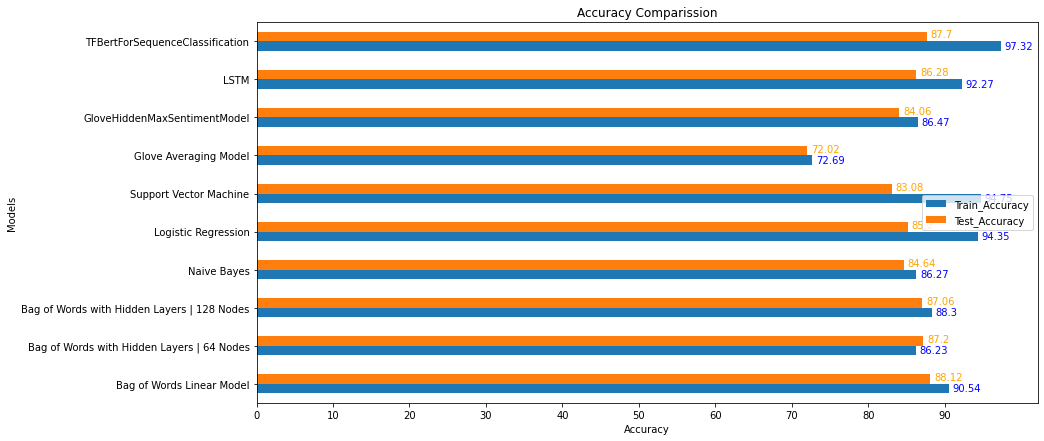

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Train_Accuracy = Accuracy_Table['Train_Accuracy']
Test_Accuracy = Accuracy_Table['Test_Accuracy']
Model = Accuracy_Table['Model']
   
data = {'Train_Accuracy': Train_Accuracy,
        'Test_Accuracy': Test_Accuracy,
        'Model':Model
       }

df = pd.DataFrame(data,columns=['Train_Accuracy','Test_Accuracy','Model'],index=[0,1,2,3,4,5,6,7,8,9])
df.set_index('Model',inplace=True)

df.plot.barh(figsize=(14,7))

for i, v in enumerate(Train_Accuracy):
    plt.text(v+0.5, i -0.2, str(v), color='blue')
for i, v in enumerate(Test_Accuracy):
    plt.text(v+0.5, i +0.1, str(v), color='orange')

plt.title('Accuracy Comparission')
plt.ylabel('Models')
plt.xlabel('Accuracy')
plt.xticks(np.arange(0, 100, 10))

plt.show()

The above bar chart represents the Accuracy of various models for IMDB Large Movie Dataset. The various Machine Learning Models(Logistic Regression, Naive Bayes, SVM)do not perform very well for the IMDB Large Movie dataset. We can conclude from the above Bar plot that TFBertForSequenceClassification performs the best with the accuracy of around 97% for training data and around 88% for testing data. This model can be further improved if we have more processing power of the GPU required to run the model.